In [70]:
import sys
from pathlib import Path
from argparse import ArgumentParser, Namespace
from collections import Counter
import pickle

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import geopandas as gdp
from tqdm import tqdm

sys.path.append("..")

from src.models import STR2MODEL
from src.engineer import GeoWikiEngineer, NigeriaEngineer
from src.exporters.sentinel.cloudfree import BANDS

## Initialize model

Adding args=[] makes it work for Jupyter notebook https://stackoverflow.com/questions/30656777/how-to-call-module-written-with-argparse-in-ipython-notebook

In [71]:
# Get model default args
parser = ArgumentParser()
model_args = STR2MODEL["land_cover"].add_model_specific_args(parser).parse_args(args=[]) 
model_args_dict = vars(model_args)

# Change default hyperparameters
model_args_dict['add_togo'] = False
model_args_dict['multi_headed'] = False
model_args_dict['num_classification_layers'] = 1

# Initialize model
model_args = Namespace(**model_args_dict)
model = STR2MODEL["land_cover"](model_args)
model.hparams

Number of geowiki instances in training set: 27947


Namespace(add_geowiki=True, add_togo=False, alpha=10, batch_size=64, data_folder='/home/gajo/code/togo-crop-mask/notebooks/../data', hidden_vector_size=64, learning_rate=0.001, lstm_dropout=0.2, model_base='lstm', multi_headed=False, num_classification_layers=1, num_lstm_layers=1, probability_threshold=0.5, remove_b1_b10=True)

## 1. Labels distribution

### 1a. Geowiki train and validation

Training set

In [72]:
train_loader = model.train_dataloader()
counter = Counter()
for sample in train_loader:
    x, y, weight = sample
    counter.update(y.numpy())

Number of geowiki instances in training set: 27947


In [73]:
cropland_ratio = counter[1.0] / (counter[0.0] + counter[1.0])
print(f'Cropland: {100*cropland_ratio:.1f}%')
print(f'Non-cropland: {100*(1-cropland_ratio):.1f}%')

Cropland: 22.1%
Non-cropland: 77.9%


Validation set


In [74]:
val_loader = model.val_dataloader()
counter = Counter()
for sample in val_loader:
    x, y, weight = sample
    counter.update(y.numpy())

Number of geowiki instances in validation set: 7301


In [75]:
cropland_ratio = counter[1.0] / (counter[0.0] + counter[1.0])
print(f'Cropland: {100*cropland_ratio:.1f}%')
print(f'Non-cropland: {100*(1-cropland_ratio):.1f}%')

Cropland: 21.2%
Non-cropland: 78.8%


### 1b. Nigeria farmlands test set

In [76]:
test_loader = model.test_dataloader()
counter = Counter()
for sample in test_loader:
    x, y, weight = sample
    counter.update(y.numpy())

Evaluating using the Nigeria evaluation dataset!
Number of instances in nigeria_farmlands_v2 test set: 739


In [77]:
cropland_ratio = counter[1.0] / (counter[0.0] + counter[1.0])
print(f'Cropland: {100*cropland_ratio:.1f}%')
print(f'Non-cropland: {100*(1-cropland_ratio):.1f}%')

Cropland: 53.2%
Non-cropland: 46.8%


<font color='red'> **The target dataset has a very different balance of labels, many more cropland labels compared to training and validation set!** </font>

## 2. Data distribution

Mean and std of each bands in a nice plot. Use normalizing dicts. Normalizing dict has 14 bands but my model has only 12, so we need to get the means and stdevs of only the bands the model is using.

In [78]:
# Get all bands names
full_bands = BANDS + ['NDVI'] if (model.input_size == 12) or (model.input_size == 14) else BANDS
bands_to_remove = ["B1", "B10"] if model.hparams.remove_b1_b10 else []

# Get band names that we use
indices_to_remove = []
for band in bands_to_remove:
    indices_to_remove.append(full_bands.index(band))
indices_to_keep = [i for i in range(len(full_bands)) if i not in indices_to_remove]
bands = [full_bands[index] for index in indices_to_keep]

### 2a. Geowiki train and val

In [79]:
# Keep only means and stdevs of bands we have
means_geowiki_full = model.normalizing_dict['mean'][indices_to_keep]
stdevs_geowiki_full = model.normalizing_dict['std'][indices_to_keep]

### 2b. Only Geowiki Nigeria

### 2c. Nigeria farmlands test set

Generate normalizing dictionary for nigeria farmlands test set. For normalizing the test isntances we use the mean and std from train and val set, but we save the test set one anyways for EDA on test set data distribution.

In [82]:
nigeria_engineer = NigeriaEngineer(Path('../data'))

savedir = nigeria_engineer.data_folder / "features" / nigeria_engineer.dataset
dict_path = savedir / "normalizing_dict.pkl"

# Calculate and save normalizing dict (mean and std per band) or load it
if not dict_path.exists():
    # Will process each tiff and save internally the running mean and variance
    for file_path in nigeria_engineer.geospatial_files:
        file_info = nigeria_engineer.process_filename(file_path.name, include_extended_filenames=True)
        if file_info is None:
            continue
        identifier, start_date, end_date = file_info

        instance = nigeria_engineer.process_single_file(
            file_path,
            nan_fill=0.0,
            max_nan_ratio=0.3,
            add_ndvi=True,
            calculate_normalizing_dict=True,
            start_date=start_date,
            days_per_timestep=30,
            is_test=False)

    # Calculate mean and std from the mean and variance
    normalizing_dict = nigeria_engineer.calculate_normalizing_dict()

    # Save dictionary
    with dict_path.open("wb") as f:
        pickle.dump(normalizing_dict, f)
        
else:
    with dict_path.open("rb") as f:
        normalizing_dict = pickle.load(f)
    print("Loaded normalizing dict of Nigeria test set.")

Loaded normalizing dict of Nigeria test set.


In [83]:
means_nigeria_farmlands = normalizing_dict['mean'][indices_to_keep]
stdevs_nigeria_farmlands = normalizing_dict['std'][indices_to_keep]

### Visualize distributions

Text(0.5, 0.98, 'Data distribution per band')

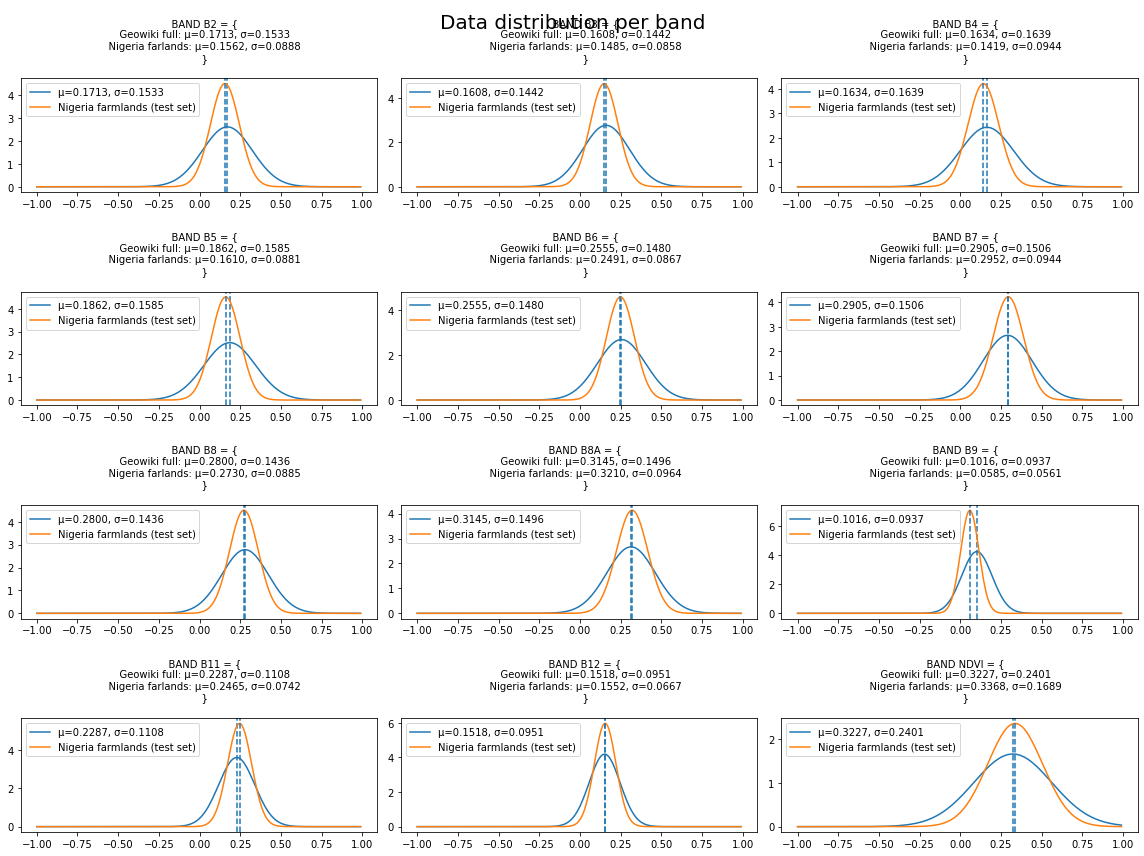

In [97]:
# Generate plots
num_plots = len(bands)
n_cols = 4
n_rows = num_plots // n_cols if num_plots % n_cols == 0 else num_plots // n_cols + 1

fig, subplots = plt.subplots(n_cols, n_rows, figsize=(16, 12))

x_axis = np.arange(-1, 1, 0.01)
for i in range(num_plots):
    
    ax = plt.subplot(n_cols, n_rows, i + 1)
    
    # Geowiki full
    mean_geowiki = means_geowiki_full[i]
    stdev_geowiki = stdevs_geowiki_full[i]
    ax.plot(x_axis, norm.pdf(x_axis, mean_geowiki, stdev_geowiki), label='Geowiki full (except some testing points nigeria')
    ax.axvline(mean_geowiki, ls='--')

    # Nigeria farmlands (test set)
    mean_nigeria_farmlands = means_nigeria_farmlands[i]
    stdev_nigeria_farmlands = stdevs_nigeria_farmlands[i]
    ax.plot(x_axis, norm.pdf(x_axis, mean_nigeria_farmlands, stdev_nigeria_farmlands), label='Nigeria farmlands (test set)')
    ax.axvline(mean_nigeria_farmlands, ls='--')

    ax.set_title(f'BAND {bands[i]}: \u03BC={mean_geowiki:.4f}, \u03C3={stdev_geowiki:.4f}')
    #ax.set_title(f'BAND {bands[i]}: \u03BC={mean_nigeria_farmlands:.4f}, \u03C3={stdev_nigeria_farmlands:.4f}')

plt.legend(bbox_to_anchor=(-0.1, 6.2), fontsize=12)
plt.subplots_adjust(top=0.85, hspace=0.5)
fig.tight_layout()
fig.suptitle('Data distribution per band', fontsize=20)
    

<font color='red'> **The data distribution of the Nigeria farmlands test set has similar mean but a much lower variance compared to geowiki.** </font>

TODOs:
- Have subplot legend where I include each mean and std values per color. Also have overall figure legend with colors.
- Add Geowiki Nigeria subset
- Visualize distribution per class as well
